In [ ]:
# !pip install grape

In [ ]:
from grape.datasets.kghub import KGIDG
import pandas as pd
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import PerceptronEdgePrediction
from grape.embedders import FirstOrderLINEEnsmallen, SecondOrderLINEEnsmallen
from grape.embedders import DeepWalkCBOWEnsmallen, DeepWalkSkipGramEnsmallen
from grape.embedders import WalkletsCBOWEnsmallen, WalkletsSkipGramEnsmallen
from grape.embedders import HOPEEnsmallen

In [ ]:
g = KGIDG(version='20230601')
main_component = g.remove_components(top_k_components=1)
dense_main_component = main_component.remove_dendritic_trees()
drug_types = ["biolink:ChemicalSubstance", "biolink:ChemicalEntity", "biolink:Drug"]
protein_types = ["biolink:Protein"]
minority_edge_type = 'minority_edge'
dense_main_component.replace_edge_type_name_from_edge_node_type_names_inplace(
    edge_type_name=minority_edge_type,
    source_node_type_names=drug_types,
    destination_node_type_names=protein_types
)  
dense_main_component

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

graph = dense_main_component.filter_from_names(edge_type_names_to_keep=[minority_edge_type])
composite_graph = dense_main_component

negative = graph.sample_negative_graph(
    number_of_negative_samples=graph.get_number_of_edges(),
    use_scale_free_distribution=False,
)

negative_scale_free = graph.sample_negative_graph(
    number_of_negative_samples=graph.get_number_of_edges(),
    use_scale_free_distribution=True,
)

existing_edges_pa = composite_graph.get_preferential_attachment_scores(
    normalize=True,
    subgraph=graph
)
uniform_negative_pa = composite_graph.get_preferential_attachment_scores(
    normalize=True,
    subgraph=negative
)
degree_negative_pa = composite_graph.get_preferential_attachment_scores(
    normalize=True,
    subgraph=negative_scale_free
)


fig, axes = plt.subplots(dpi=400)

plt.hist(
    [
        existing_edges_pa,
        uniform_negative_pa,
        degree_negative_pa
    ],
    log=True,
    bins=40,
    label=[
        "Existing edges",
        "Uniform non-existing edges",
        "Degree non-existing edges"
    ]
)
plt.legend()

In [ ]:
# Set smoke test to True for testing:
# SMOKE_TEST = True
NUMBER_OF_HOLDOUTS = 10
VALIDATION_UNBALANCE_RATES = (1.0, )
TRAIN_SIZES = (0.75,)
subgraph = dense_main_component.filter_from_names(
    edge_type_names_to_keep=[minority_edge_type]
)
# Disable the smoke test when you need to run the real thing:
SMOKE_TEST = False
NUMBER_OF_HOLDOUTS = 10
VALIDATION_UNBALANCE_RATES = (1.0, )
TRAIN_SIZES = (0.75,)
results = []
for train_size in TRAIN_SIZES:
    for validation_use_scale_free in (True, False):
        for ModelClass in  [
                FirstOrderLINEEnsmallen,
                SecondOrderLINEEnsmallen,
                DeepWalkCBOWEnsmallen, DeepWalkSkipGramEnsmallen,
                WalkletsCBOWEnsmallen, WalkletsSkipGramEnsmallen,
                HOPEEnsmallen
            ]:
            # If the embedding method involves edge sampling, we train a run
            # using the scale free and one using the uniform.
            if "use_scale_free_distribution" in ModelClass().parameters():
                parameter_sets = [
                    # dict(
                    #     use_scale_free_distribution = True
                    # ),
                    dict(
                        use_scale_free_distribution = False
                    )
                ]
            else:
                parameter_sets = [dict()]
            print(f"train size: {train_size}; validation_use_scale_free: {validation_use_scale_free} ModelClass {ModelClass}")
            for parameter_set in parameter_sets:
                results.append(edge_prediction_evaluation(
                    smoke_test=SMOKE_TEST,
                    holdouts_kwargs=dict(
                        train_size=train_size,
                        edge_types=[minority_edge_type],
                    ),
                    evaluation_schema="Connected Monte Carlo",
                    node_features=ModelClass(**parameter_set),
                    graphs=dense_main_component,
                    models=[
                        PerceptronEdgePrediction(
                            edge_features=None,
                            edge_embeddings="Hadamard",
                            number_of_edges_per_mini_batch=32,
                            use_scale_free_distribution=use_scale_free_distribution
                        )
                        # for use_scale_free_distribution in (True, False)
                        for use_scale_free_distribution in [False]
                    ],
                    enable_cache=True,
                    number_of_holdouts=NUMBER_OF_HOLDOUTS,
                    use_scale_free_distribution=validation_use_scale_free,
                    validation_unbalance_rates=VALIDATION_UNBALANCE_RATES,
                    subgraph_of_interest=subgraph,
                    use_subgraph_as_support=False
                ))
results = pd.concat(results)
results.to_csv("kg_idg_negative_select.tsv",sep="\t")

In [ ]:
from glob import glob 
paths = glob("experiments/Ed*/KGIDG/*gz")
paths
import pandas as pd 
df = pd.concat([pd.read_csv(path, index_col=0) for path in paths]).reset_index(drop=True)
df.to_csv("dans_kg_idg_raw_data.csv")

In [3]:
gb = ['evaluation_mode', 'use_scale_free_distribution', 'features_names', "('model_parameters', 'use_scale_free_distribution')",  "('features_parameters', 'use_scale_free_distribution')"]
metrics = ['matthews_correlation_coefficient']
df = df[df["('model_parameters', 'use_scale_free_distribution')"] == False]
df = df[df["('features_parameters', 'use_scale_free_distribution')"] == False]
sf_df = df[[*gb, *metrics]].groupby(gb).agg(['mean', 'std'])
sf_df.to_csv("dans_kg_idg_data.csv")
sf_df
data = sf_df
data = data.reset_index()
data

evaluation_mode use_scale_free_distribution     features_names  \
                                                                    
0             test                       False      DeepWalk CBOW   
1             test                       False  DeepWalk SkipGram   
2             test                       False   First-order LINE   
3             test                       False  Second-order LINE   
4             test                       False      Walklets CBOW   
5             test                       False  Walklets SkipGram   
6             test                        True      DeepWalk CBOW   
7             test                        True  DeepWalk SkipGram   
8             test                        True   First-order LINE   
9             test                        True  Second-order LINE   
10            test                        True      Walklets CBOW   
11            test                        True  Walklets SkipGram   
12           train                       False      DeepWalk CBOW   
13           train                       False  DeepWalk SkipGram   
14           train                       False   First-order LINE   
15           train                       False  Second-order LINE   
16           train                       False      Walklets CBOW   
17           train                       False  Walklets SkipGram   
18           train                        True      DeepWalk CBOW   
19           train                        True  DeepWalk SkipGram   
20           train                        True   First-order LINE   
21           train                        True  Second-order LINE   
22           train                        True      Walklets CBOW   
23           train                        True  Walklets SkipGram   

   ('model_parameters', 'use_scale_free_distribution')  \
                                                         
0                                               False    
1                                               False    
2                                               False    
3                                               False    
4                                               False    
5                                               False    
6                                               False    
7                                               False    
8                                               False    
9                                               False    
10                                              False    
11                                              False    
12                                              False    
13                                              False    
14                                              False    
15                                              False    
16                                              False    
17                                              False    
18                                              False    
19                                              False    
20                                              False    
21                                              False    
22                                              False    
23                                              False    

   ('features_parameters', 'use_scale_free_distribution')  \
                                                            
0                                               False       
1                                               False       
2                                               False       
3                                               False       
4                                               False       
5                                               False       
6                                               False       
7                                               False       
8                                               False       
9                           

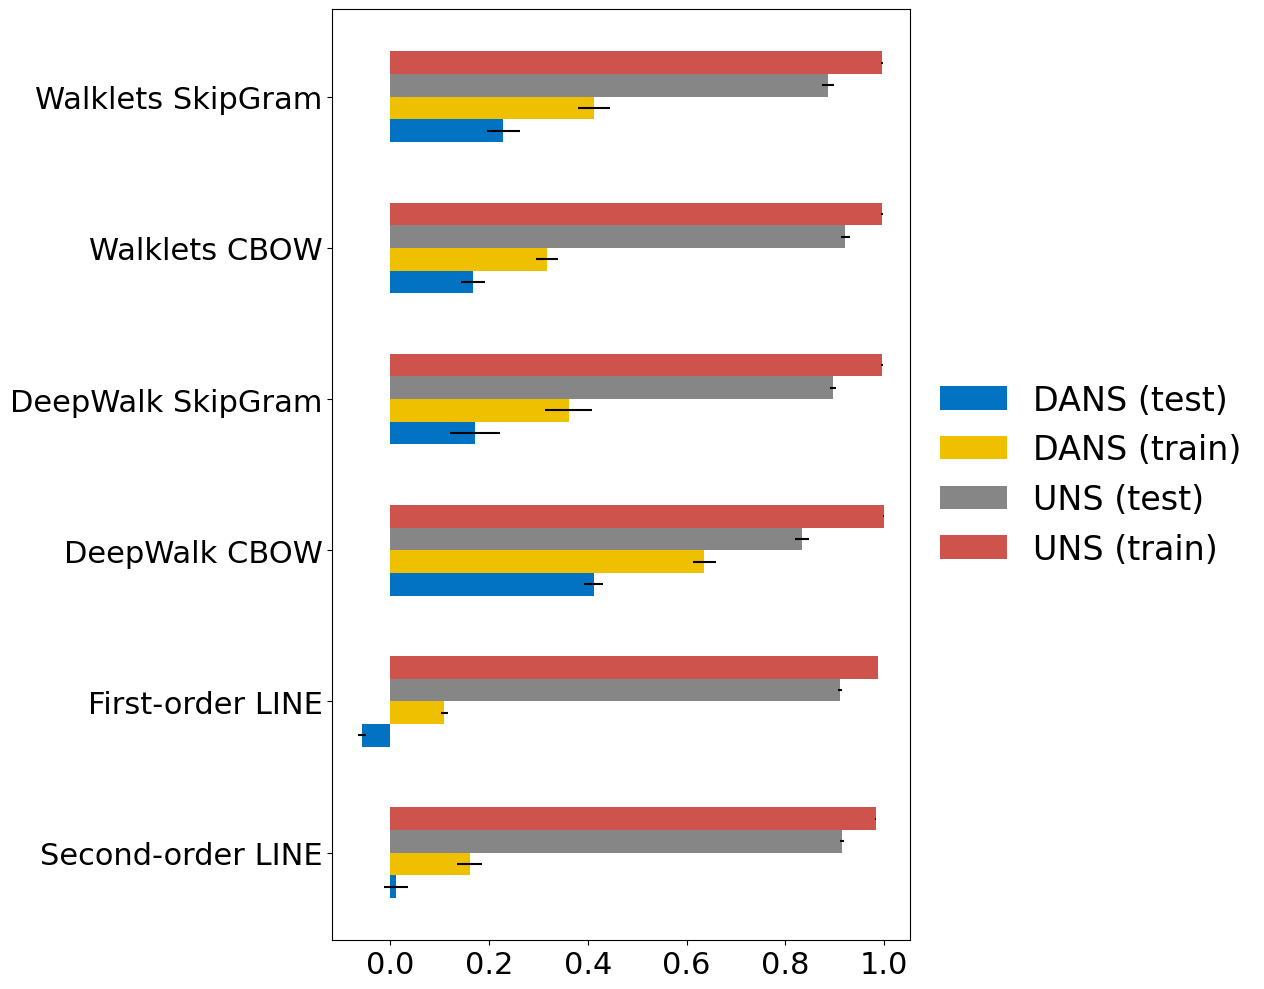

In [13]:
# Plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Custom colors for the plot
colors = {
    'False_False': '#868686',  # UNS (Test) - grey
    'False_True': '#cd534c',   # UNS (Train) - red
    'True_False': '#0273c2',   # DANS (Test) - blue
    'True_True': '#eec000'     # DANS (Train) - yellow
}

# Specified order of features
features_order = [
    'Walklets SkipGram',
    'Walklets CBOW',
    'DeepWalk SkipGram',
    'DeepWalk CBOW',
    'First-order LINE',
    'Second-order LINE'
]

# Reorder the DataFrame
data['features_names'] = pd.Categorical(data['features_names'], categories=features_order, ordered=True)
# data.sort_values('features_names', ascending=False, inplace=True)
data

# Creating figure and axes
fig, ax = plt.subplots(figsize=(15, 10))

bar_height = 0.15
index = np.arange(len(data['features_names'].unique()))
for i, (scale_free, mode) in enumerate([(True, False), (True, True), (False, False), (False, True)]):
    subset = data[(data['use_scale_free_distribution'] == scale_free) & (data['evaluation_mode'] == ('test' if mode == False else 'train'))]
    if not subset.empty:
        ax.barh(index + i * bar_height,
                subset[('matthews_correlation_coefficient', 'mean')],
                bar_height,
                xerr=subset[('matthews_correlation_coefficient', 'std')],
                color=colors[f'{scale_free}_{mode}'],
                label='UNS (test)' if scale_free == False and mode == False else (
                      'UNS (train)' if scale_free == False and mode == True else (
                      'DANS (test)' if scale_free == True and mode == False else 'DANS (train)')))

ax.set_xlabel('')
ax.set_yticks(index + bar_height * 1.5)
ax.set_yticklabels(features_order[::-1])
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=24)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()